Setar as tabelas existentes para poder realizar as consultas posteriormente:

In [ ]:
import sqlite3
import pandas as pd

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create sample tables
cursor.execute('''
CREATE TABLE employees (
    employee_id INTEGER PRIMARY KEY,
    name TEXT,
    department_id INTEGER,
    salary REAL
)
''')

cursor.execute('''
CREATE TABLE departments (
    department_id INTEGER PRIMARY KEY,
    department_name TEXT
)
''')

cursor.execute('''
CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY,
    employee_id INTEGER,
    sale_amount REAL,
    sale_date TEXT
)
''')

# Insert sample data
cursor.execute("INSERT INTO employees VALUES (1, 'Alice', 101, 60000)")
cursor.execute("INSERT INTO employees VALUES (2, 'Bob', 102, 75000)")
cursor.execute("INSERT INTO employees VALUES (3, 'Charlie', 101, 65000)")
cursor.execute("INSERT INTO employees VALUES (4, 'David', 103, 90000)")
cursor.execute("INSERT INTO employees VALUES (5, 'Eve', 102, 70000)")

cursor.execute("INSERT INTO departments VALUES (101, 'Sales')")
cursor.execute("INSERT INTO departments VALUES (102, 'Marketing')")
cursor.execute("INSERT INTO departments VALUES (103, 'IT')")

cursor.execute("INSERT INTO sales VALUES (1001, 1, 5000, '2023-01-15')")
cursor.execute("INSERT INTO sales VALUES (1002, 2, 3000, '2023-01-20')")
cursor.execute("INSERT INTO sales VALUES (1003, 1, 6000, '2023-02-10')")
cursor.execute("INSERT INTO sales VALUES (1004, 3, 4000, '2023-02-15')")
cursor.execute("INSERT INTO sales VALUES (1005, 2, 3500, '2023-03-01')")
cursor.execute("INSERT INTO sales VALUES (1006, 4, 8000, '2023-03-05')")
cursor.execute("INSERT INTO sales VALUES (1007, 1, 5500, '2023-03-10')")

conn.commit()

print("Database and tables created successfully with sample data.")

Database and tables created successfully with sample data.


Cenário do problema:

## Cenário de Negócio: Análise de Vendas por Departamento e Funcionário

Este cenário simula um sistema simples de gestão de funcionários, departamentos e vendas. O objetivo é analisar o desempenho de vendas dos funcionários e dos departamentos aos quais pertencem.

### Tabelas:

1.  **`employees`**: Armazena informações sobre os funcionários.
    *   `employee_id` (Chave Primária): Identificador único do funcionário.
    *   `name`: Nome do funcionário.
    *   `department_id` (Chave Estrangeira referenciando `departments`): O departamento ao qual o funcionário pertence.
    *   `salary`: Salário do funcionário.

2.  **`departments`**: Armazena informações sobre os departamentos da empresa.
    *   `department_id` (Chave Primária): Identificador único do departamento.
    *   `department_name`: Nome do departamento.

3.  **`sales`**: Armazena informações sobre as vendas realizadas pelos funcionários.
    *   `sale_id` (Chave Primária): Identificador único da venda.
    *   `employee_id` (Chave Estrangeira referenciando `employees`): O funcionário que realizou a venda.
    *   `sale_amount`: O valor da venda.
    *   `sale_date`: A data em que a venda foi realizada.

### Relacionamentos:

*   A tabela `employees` está relacionada à tabela `departments` através da chave estrangeira `department_id`. Isso indica que cada funcionário pertence a um departamento. Um departamento pode ter vários funcionários.
*   A tabela `sales` está relacionada à tabela `employees` através da chave estrangeira `employee_id`. Isso indica qual funcionário realizou cada venda. Um funcionário pode realizar várias vendas.

## Problema: Análise de Desempenho de Vendas com Classificação por Departamento

Com base nas tabelas `employees`, `departments` e `sales`, o problema a ser resolvido é o seguinte:

**Para cada funcionário, calcule o total de vendas realizadas e a média de vendas do departamento ao qual ele pertence. Além disso, classifique os funcionários dentro de cada departamento com base no total de vendas, atribuindo um ranking (do maior para o menor total de vendas).**

A solução deve apresentar as seguintes informações para cada funcionário:

*   Nome do funcionário (`name`)
*   Nome do departamento (`department_name`)
*   Total de vendas do funcionário (`total_employee_sales`)
*   Média de vendas do departamento (`average_department_sales`)
*   Ranking do funcionário dentro do departamento baseado no total de vendas (`department_sales_rank`)

Este problema exige a combinação de dados de diferentes tabelas (JOINs), o cálculo agregado de vendas por funcionário e por departamento (que pode ser facilitado com CTEs ou Subqueries), e a aplicação de funções de janela (Window Functions) para o cálculo da média do departamento e para a classificação dos funcionários dentro de seus respectivos departamentos.

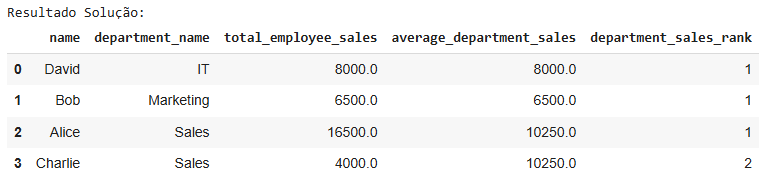

Exemplo de como realizar consultas:

In [ ]:
# Exemplo de consulta: Selecionar todos os funcionários
query_employees = "SELECT * FROM employees"
df_employees = pd.read_sql_query(query_employees, conn)
print("Dados da tabela 'employees':")
display(df_employees)

# Exemplo de consulta: Selecionar todos os departamentos
query_departments = "SELECT * FROM departments"
df_departments = pd.read_sql_query(query_departments, conn)
print("\nDados da tabela 'departments':")
display(df_departments)

# Exemplo de consulta: Selecionar todas as vendas
query_sales = "SELECT * FROM sales"
df_sales = pd.read_sql_query(query_sales, conn)
print("\nDados da tabela 'sales':")
display(df_sales)

Dados da tabela 'employees':


,employee_id,name,department_id,salary
0,1,Alice,101,60000.0
1,2,Bob,102,75000.0
2,3,Charlie,101,65000.0
3,4,David,103,90000.0
4,5,Eve,102,70000.0



Dados da tabela 'departments':


,department_id,department_name
0,101,Sales
1,102,Marketing
2,103,IT



Dados da tabela 'sales':


,sale_id,employee_id,sale_amount,sale_date
0,1001,1,5000.0,2023-01-15
1,1002,2,3000.0,2023-01-20
2,1003,1,6000.0,2023-02-10
3,1004,3,4000.0,2023-02-15
4,1005,2,3500.0,2023-03-01
5,1006,4,8000.0,2023-03-05
6,1007,1,5500.0,2023-03-10


Defina sua solução:

In [98]:
query_solucao = """
WITH soma_vendas AS (
  SELECT e.employee_id, e.name, e.department_id, SUM(s.sale_amount) AS total_employee_sales
  FROM employees e
  JOIN sales s
  ON e.employee_id = s.employee_id
  GROUP BY e.name
),
media_vendas_depart AS (
  SELECT sv.department_id, AVG(sv.total_employee_sales) AS average_department_sales
  FROM soma_vendas sv
  GROUP BY sv.department_id
),
ranking AS (
  SELECT sv.employee_id, sv.department_id, sv.total_employee_sales,
  RANK() OVER(PARTITION BY sv.department_id ORDER BY sv.total_employee_sales DESC) AS department_sales_rank
FROM soma_vendas sv
)
SELECT e.name, d.department_name, sv.total_employee_sales, mvd.average_department_sales, r.department_sales_rank
FROM employees e
JOIN departments d ON e.department_id = d.department_id
JOIN soma_vendas sv ON e.employee_id = sv.employee_id
JOIN media_vendas_depart mvd ON mvd.department_id = d.department_id
JOIN ranking r ON r.employee_id = e.employee_id
"""

df_query = pd.read_sql_query(query_solucao, conn)
print("\nResultado Solução:")
display(df_query)


Resultado Solução:


,name,department_name,total_employee_sales,average_department_sales,department_sales_rank
0,Alice,Sales,16500.0,10250.0,1
1,Bob,Marketing,6500.0,6500.0,1
2,Charlie,Sales,4000.0,10250.0,2
3,David,IT,8000.0,8000.0,1
